https://kaggle-kr.tistory.com/32 


https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python/notebook

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
#from sklearn.cross_validation import KFold 
#=> cross_validation에서 model_selection으로 이름 바뀜.

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

# Feature Exploration, Engineering and Cleaning

In [ ]:
#데이터 로드
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/titanic/test.csv')

In [ ]:
#easy access를 위해 passenger ID 따로 저장
PassengerId = test['PassengerId']

train.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

## Feature Engineering

In [ ]:
full_data = [train, test]

#Name_length 피처 추가
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

#Has_Cabin 피처 생성 (whether a passenger had a cabin on the Titanic) => Cabin 피처 null인지 아닌지
train['Has_Cabin'] = train['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x : 0 if type(x) == float else 1)

#Family size 피처 생성
for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

#IsAlone 피처 생성
for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

#Embarked 에서 null 제거('S'로 대체)
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

#Fare 피처에서 null 제거(평균 대체)
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

#CategoricalFare 피처 생성
train['CategoricalFare'] = pd.qcut(train['Fare'], 4) #+) pd.qcut() : 동일한 데이터 개수로 구간을 나눔

# CategoricalAge 피처 생성
#+) null값 random으로 처리
for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count) 
  dataset['Age'][np.isnan(dataset['Age'])]
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5) #+) pd.cut() : 동일한 길이로 구간을 나눔

# passenger name 추출하는 함수
def get_title(name):
  title_search = re.search(' ([A-Za-z]+)\.', name)
  # If title 있으면 추출해서 return
  if title_search:
      return title_search.group(1)
  return ""

# Title 피처 생성 (containing the titles of passenger names) ex) Mr, Mrs
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [ ]:
#숫자로 mapping

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

## Feature selection

In [ ]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)#..?
test  = test.drop(drop_elements, axis = 1)


## Visualisations

In [ ]:
train.head(3)

Survived  Pclass  Sex  Age  Parch  Fare  Embarked  Name_length  Has_Cabin  \
0         0       3    1    1      0     0         0           23          0   
1         1       1    0    2      0     3         1           51          1   
2         1       3    0    1      0     1         0           22          0   

   FamilySize  IsAlone  Title  
0           2        0      1  
1           2        0      3  
2           1        1      2

## Pearson Correlation Heatmap

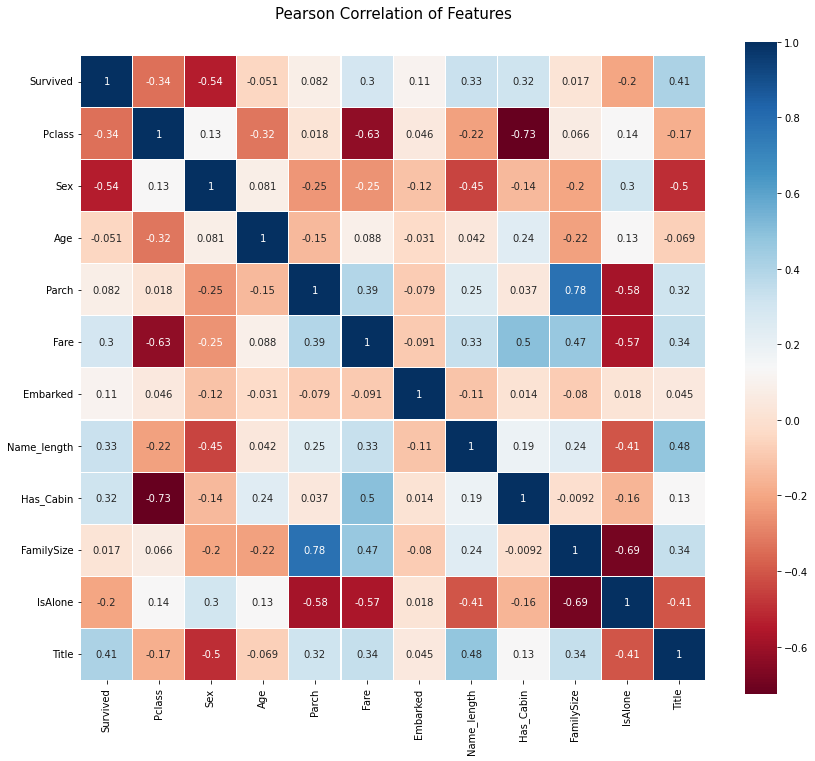

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

서로 강한 상관관계인 피처는 많지 않음. 


=> 중복되거나 불필요한 중복되거나 불필요한 데이터가 많지 않고, 각 기능이 일부 고유한 정보를 가지고 있다는 것을 의미


FamilySize, Parch가 상관관계 높음.

## Pairplots

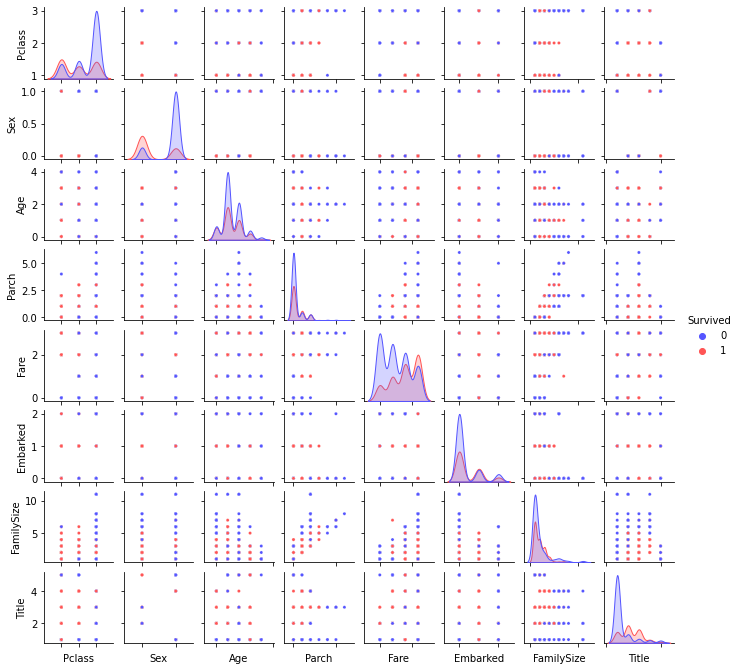

In [ ]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling & Stacking models

## Helpers via Python Classes

Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [ ]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
'''kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)'''
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

Bear with me for those who already know this but for people who have not created classes or objects in Python before, let me explain what the code given above does. In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that.

def init : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.

## Out-of-Fold Predictions

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    n_iter = 0 #+
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    #for i, (train_index, test_index) in enumerate(kf):
    for train_index, test_index in kf.split(train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[n_iter, :] = clf.predict(x_test)
        n_iter+=1 #+
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models

1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

**Parameters**

Just a quick summary of the parameters that we will be listing here for completeness,

n_jobs : Number of cores used for the training process. If set to -1, all cores are used.

n_estimators : Number of classification trees in your learning model ( set to 10 per default)

max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep

verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

### Parameters

In [ ]:
#파라미터
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [ ]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### **Creating NumPy arrays out of our train and test sets**

In [ ]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

### **Output of the First level Predictions**

We now feed the training and test data into our 5 base classifiers and use the `Out-of-Fold `prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [ ]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### **Feature importances**

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.10231642 0.20892695 0.0327357  0.01947124 0.04866141 0.02924952
 0.13222627 0.0502064  0.07086821 0.01217283 0.29316504]
[0.12141548 0.37837298 0.02865883 0.01702293 0.05533056 0.02745859
 0.04680892 0.08220651 0.04413537 0.02265787 0.17593195]
[0.03  0.012 0.024 0.068 0.038 0.01  0.674 0.014 0.054 0.002 0.074]
[0.08997998 0.00999379 0.04866231 0.01365515 0.05384909 0.02346659
 0.1760826  0.0376287  0.10789312 0.00803855 0.43075012]


In [ ]:
rf_features = [0.10474135, 0.21837029, 0.04432652, 0.02249159, 0.05432591, 0.02854371, 0.07570305, 0.01088129, 0.24247496, 0.13685733, 0.06128402]
et_features = [0.12165657, 0.37098307, 0.03129623, 0.01591611, 0.05525811, 0.028157, 0.04589793, 0.02030357, 0.17289562, 0.04853517,  0.08910063]
ada_features = [0.028, 0.008, 0.012, 0.05866667, 0.032, 0.008, 0.04666667, 0., 0.05733333, 0.73866667, 0.01066667]
gb_features = [0.06796144, 0.03889349, 0.07237845, 0.02628645, 0.11194395, 0.04778854, 0.05965792, 0.02774745, 0.07462718, 0.4593142, 0.01340093]

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [ ]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

### **Interactive feature importances via Plotly scatterplots**

**Random Forest**

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        #size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

**Extra Trees**

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        #size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

**AdaBoost**

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        #size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

**Gradient Boost**

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        #size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### Mean of feature importances

In [ ]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

features  Random Forest feature importances  \
0   Pclass                           0.104741   
1      Sex                           0.218370   
2      Age                           0.044327   

   Extra Trees  feature importances  AdaBoost feature importances  \
0                          0.121657                         0.028   
1                          0.370983                         0.008   
2                          0.031296                         0.012   

   Gradient Boost feature importances      mean  
0                            0.067961  0.080590  
1                            0.038893  0.159062  
2                            0.072378  0.040000

### Plotly Barplot of Average Feature Importances

In [ ]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
            y= y,
            width = 0.5,
            marker=dict(
              color = feature_dataframe['mean'].values,
              colorscale='Portland',
              showscale=True,
              reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#   xaxis= dict(
#       title= 'Pop',
#       ticklen= 5,
#       zeroline= False,
#       gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

### First-level output as new features

In [ ]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
     'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

RandomForest  ExtraTrees  AdaBoost  GradientBoost
0           0.0         0.0       0.0            0.0
1           1.0         1.0       1.0            1.0
2           1.0         0.0       1.0            1.0
3           1.0         1.0       1.0            1.0
4           0.0         0.0       0.0            0.0

### Correlation Heatmap of the Second Level Training set

In [ ]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
        colorscale='Viridis',
        showscale=True,
        reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

### first-level output concatenate

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost

In [ ]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,                        
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

+) parameters

max_depth : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

gamma : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

eta : step size shrinkage used in each boosting step to prevent overfitting

# Submission

In [ ]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)